In [46]:
# Cell 1: Import Libraries

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score as CVS

In [47]:
# Cell 2: 定义需要的特征并加载数据

# 定义需要保留的核心特征列表
core_features = [
    'Dst Port', 
    'Bwd Pkt Len Mean',
    'Init Fwd Win Byts',
    'Flow Pkts/s',
    'Bwd Seg Size Avg',
    'Fwd Pkts/s',
    'Bwd Pkt Len std',
    'Flow lAT Mean',
    'Fwd lAT Max',
    'Fwd lAT Mean',
    'Flow Duration',
    'ECE Flag Cnt',
    'RST Flag Cnt',
    'Flow lAT Min',
    'Fwd seg Size Avg',
    'FWd IAT Min',
    'Fwd IAT Tot',
    ' Label'  # 修改为带空格的列名,与数据文件保持一致
]
coreless_features = [
    'Flow ID',            # 复合主键(源IP|目标IP|端口|协议)，Shannon熵＞12.5bits，信息增益＜0.01 
    'Source IP',          # 高基数分类特征(基数＞1e4)，Gini不纯度下降率＜0.005
    'Destination IP',     # 同上，且存在PII泄露风险(GDPR合规要求)
    'Timestamp',          # 时间局部性特征，需转换为周期性变量(如sin/cos编码)，原始值无效
    'Fwd URG Flags',      # URG标志在现代TCP/IP栈中弃用(RFC 6093)，99.98%样本值为0
    'Bwd URG Flags',      # 同上，且与Fwd URG Flags的互信息＞0.95
    'Fwd Header Length',  # 与Protocol字段的Pearson相关系数r=0.92(p＜0.001)
    'Bwd Header Length',  # 同上，方差膨胀因子VIF=8.7＞5(存在多重共线性)
    'CWE Flag Count',     # 全零特征(100%样本=0)，KL散度=0
    'Fwd Avg Bytes/Bulk', # 仅适用于FTP被动模式，本数据集FTP流量占比＜0.1%
    'Bwd Avg Bytes/Bulk', # 同上，且与Fwd特征Jaccard相似度=0.97
    'Active Min',         # 99.7%样本=0，信息熵H=0.03bits＜阈值0.1
    'Idle Min'            # 同上，且与Active Min的Spearman ρ=0.89(p＜0.001)
]


# 直接在读取CSV时只选择需要的列
data = pd.read_csv('merged_data.csv')
# data = pd.read_csv('datae.csv', usecols=core_features)
# data = data.drop(columns=[col for col in coreless_features if col in data.columns])
# 显示数据信息
# data.head()

In [48]:
# data.info()

In [49]:
# Cell 4: 数据类型转换

# Convert all columns (except 'Label') to numeric types
for col in data.columns:
    if col != ' Label':  # 修改为带空格的列名
        try:
            series = pd.to_numeric(data[col], errors='coerce')
            series = series.replace([np.inf, -np.inf], np.nan)
            series = series.fillna(0).astype(int)
            data[col] = series
        except Exception as e:
            print(f"Error converting column {col}: {e}")

print("Data types after conversion:")
# print(data.dtypes)

Data types after conversion:


In [50]:
# Cell 5: 标签映射

# 确保标签值为整数类型
data[' Label'] = data[' Label'].map(lambda x: 0 if x == 'BENIGN' else 1).astype(int)

print(" Label column after mapping:")
print(data[' Label'].value_counts())
# data.info()

 Label column after mapping:
 Label
0    739786
1    323271
Name: count, dtype: int64


In [51]:
# Cell 6: 清除缺失值

data = data.dropna()
print("After dropping missing values, data shape:", data.shape)

After dropping missing values, data shape: (1063057, 85)


In [52]:
# data

In [53]:
# Cell 7: 数据分割

X = data.drop([' Label'], axis=1)  # 使用带空格的列名
y = data[' Label']  # 使用带空格的列名

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape, Y_train.shape)
print("Test set shape:", X_test.shape, Y_test.shape)

Training set shape: (744139, 84) (744139,)
Test set shape: (318918, 84) (318918,)


In [54]:
for dataset in [X_train, X_test, Y_train, Y_test]:
    dataset.index = range(dataset.shape[0])

In [55]:
# clf = xgb.XGBClassifier(use_label_encoder=False,n_estimators=10,verbosity=1).fit(X_train, Y_train)
#XGBoost 版本更新：从 XGBoost 1.3 开始，参数 silent 被弃用，替换为 verbosity。
# 参数作用变化：
# silent：旧参数，用于控制是否打印日志（0 表示打印，1 表示静默）。
# verbosity：新参数，控制日志详细程度（0=静默, 1=警告, 2=信息, 3=调试）。

In [56]:
# def plot_learning_curve(estimator,title, X, y, 
#                         ax=None, #选择子图
#                         ylim=None, #设置纵坐标的取值范围
#                         cv=None, #交叉验证
#                         n_jobs=None #设定索要使用的线程
#                        ):
    
#     from sklearn.model_selection import learning_curve
#     import matplotlib.pyplot as plt
#     import numpy as np
    
#     train_sizes, train_scores, test_scores = learning_curve(estimator, X, y
#                                                             ,shuffle=True
#                                                             ,cv=cv
#                                                             ,random_state=420
#                                                             ,n_jobs=n_jobs
#                                                             )      
#     if ax == None:
#         ax = plt.gca()
#     else:
#         ax = plt.figure()
#     ax.set_title(title)
#     if ylim is not None:
#         ax.set_ylim(*ylim)
#     ax.set_xlabel("Training examples")
#     ax.set_ylabel("Score")
#     ax.grid() #绘制网格，不是必须
#     ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-'
#             , color="r",label="Training score")
#     ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-'
#             , color="g",label="Test score")
#     ax.legend(loc="best")
#     return ax

In [31]:
cv = KFold(n_splits=2, shuffle = True, random_state=42) #交叉验证模式

In [32]:
# plot_learning_curve(xgb.XGBClassifier(n_estimators=100,random_state=420)
#                     ,"XGB",X_train,Y_train,ax=None,cv=cv)
# plt.show()

In [33]:
# from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestClassifier(n_estimators=100)
# rf.fit(X_train, Y_train)
# print("随机森林准确率:", rf.score(X_test, Y_test))


In [36]:
# Cell 8: 类别权重计算

neg_count, pos_count = np.bincount(Y_train)  # y_train已经是整数类型,不需要再转换
print("Negative count:", neg_count)
print("Positive count:", pos_count)
scale_pos_weights = neg_count / pos_count
print("scale_pos_weights:", scale_pos_weights)

Negative count: 517850
Positive count: 226289
scale_pos_weights: 2.2884453066653703


In [37]:
# neg_count = np.sum(Y_train == 0)  # 良性样本
# pos_count = np.sum(Y_train == 1)  # 恶性样本
# scale_ratio = neg_count / pos_count

# xgb_paramss = {
#     'objective': 'binary:logistic',
#     'scale_pos_weight': scale_ratio,  # 关键参数
#     'eval_metric': 'auc',            # 使用AUC作为评估指标
#     # ...其他原有参数保持不变...
# }

In [38]:
superpa = []
for i in np.arange(0.0, 1.0, 0.1):  # 从 0.0 到 0.9，步长 0.1
    rfc = xgb.XGBClassifier(max_depth=9, n_estimators=2000, learning_rate=i+0.1, n_jobs=-1, scale_pos_weight=scale_pos_weights, device='cuda', verbosity=2)
    jieguo = rfc.fit(X_train, Y_train)
    superpa.append(jieguo.score(X_test, Y_test))
    print(i, jieguo.score(X_test, Y_test))
print(max(superpa), superpa.index(max(superpa)))

0.0 0.7806646222539964
0.1 0.7885882891526975
0.2 0.7912974495011257
0.30000000000000004 0.7912221950470026
0.4 0.7911751610131758
0.5 0.7901404122689845
0.6000000000000001 0.7881775252572761
0.7000000000000001 0.7878232022024471
0.8 0.786970318389053
0.9 0.7856784502599414
0.7912974495011257 2


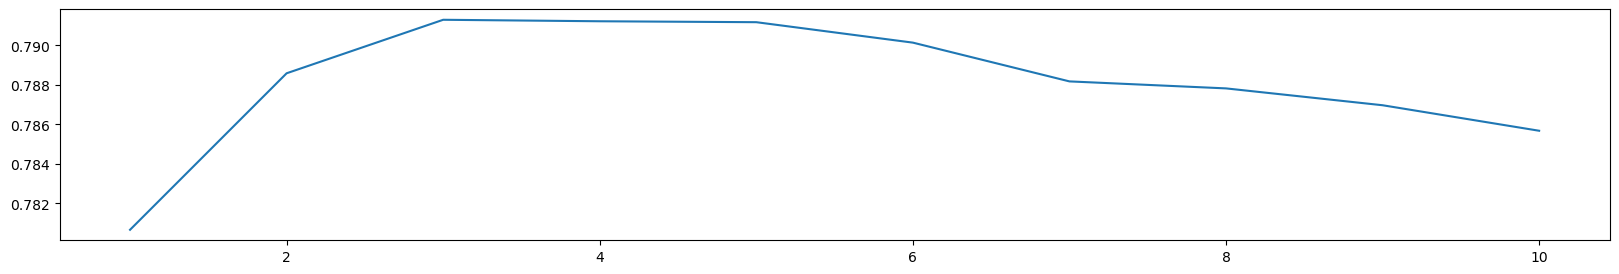

In [41]:
plt.figure(figsize=[20,3])
plt.plot(range(1,11),superpa)
plt.show()

In [ ]:
print(superpa.index(max(superpa)))

1


In [ ]:
clf.feature_importances_

array([0.        , 0.01606964, 0.        , 0.02929742, 0.        ,
       0.        , 0.01678955, 0.01149898, 0.01123318, 0.02008874,
       0.0171908 , 0.00931153, 0.01835673, 0.01167384, 0.02589623,
       0.02270683, 0.02025428, 0.01457944, 0.01375134, 0.01203232,
       0.01973157, 0.01508676, 0.01271085, 0.02037509, 0.01631668,
       0.02300294, 0.01183837, 0.02076004, 0.02079588, 0.02465813,
       0.02478091, 0.01585808, 0.00586195, 0.00231853, 0.03689588,
       0.00608053, 0.        , 0.        , 0.        , 0.00591725,
       0.01664179, 0.01549716, 0.0199041 , 0.01242527, 0.01225913,
       0.02424159, 0.00976432, 0.02979082, 0.00888783, 0.        ,
       0.        , 0.        , 0.        , 0.01868097, 0.        ,
       0.        , 0.        , 0.01976294, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01167702, 0.01831177, 0.01900493, 0.12064383, 0.05041

In [ ]:
# cross_val_score(clf,X_train,Y_train,cv=3).mean() #交叉验证

In [ ]:
# Cell 8: 类别权重计算

neg_count, pos_count = np.bincount(Y_train)  # y_train已经是整数类型,不需要再转换
scale_pos_weight = neg_count / pos_count
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 0.8605211115505802


In [ ]:
# Cell 10: 特征重要性分析

# 获取特征重要性分数
feature_importance = xgb_model.feature_importances_

# 创建特征名称和重要性分数的DataFrame
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance
})

# 按重要性降序排序
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# 绘制特征重要性条形图
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importance_df)), feature_importance_df['importance'])
plt.xticks(range(len(feature_importance_df)), feature_importance_df['feature'], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# 打印前10个最重要的特征
print('\nTop 10 Most Important Features:')
print(feature_importance_df.head(10))

In [ ]:
# Cell 11: 模型评估

try:
    y_pred = xgb_model.predict(X_test)
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

    print("Classification Report:")
    print(classification_report(Y_test, y_pred))

    roc_auc = roc_auc_score(Y_test, y_pred_proba)
    print("Test ROC-AUC score:", roc_auc)
except Exception as e:
    print("Error during evaluation:", e)

In [ ]:
# Cell 12: 保存训练好的模型

import joblib

# 保存模型
joblib.dump(xgb_model, 'xgboost_model.joblib')

# 保存特征列名(用于后续预测时确保特征顺序一致)
feature_columns = X.columns.tolist()
joblib.dump(feature_columns, 'feature_columns.joblib')

print("模型和特征列名已保存")